# ⚡ Predictive Maintenance for Thermal Power Plant Turbines using Machine Learning (Perawatan Prediktif Turbin PLTU Menggunakan Machine Learning - Dummy Project)

📌 **Nama:** Difta Alzena Sakhi   
🎓 **Status**: Mahasiswa S1 Sains Data, UPN "Veteran" Jawa Timur   
🔗 **GitHub:** [github.com/diftaalzena1](https://github.com/diftaalzena1)  
📅 **Proyek Personal / Portfolio**  
🛠️ **Tools:** Python, Scikit-Learn, Pandas, Seaborn, SMOTE  

---

## 📌 Ringkasan Proyek
Sistem pembangkit listrik tenaga uap (PLTU) sangat bergantung pada kinerja turbin. Kegagalan turbin dapat menyebabkan kerugian besar dan waktu henti yang tidak direncanakan. Proyek ini bertujuan untuk membangun model klasifikasi prediktif menggunakan data sensor suhu, tekanan, dan getaran untuk mendeteksi potensi gangguan pada turbin.

Model yang dibangun dapat diintegrasikan ke dalam sistem pemantauan PLN berbasis SCADA/IIoT untuk mendeteksi dini potensi kegagalan.

## 1. Import Library

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


## 2. Pembuatan Dataset Dummy Sintetik

Dataset ini disimulasikan untuk merepresentasikan kondisi sensor pada turbin pembangkit listrik tenaga uap (PLTU). Masing-masing baris mewakili satu hari pengamatan terhadap turbin.

📌 Karakteristik Variabel:
- Hari: Tanggal observasi dari 1 Januari 2024 selama 1000 hari ke depan.
- Temperatur: Suhu operasi turbin (°C), disimulasikan dengan distribusi normal rata-rata 75°C dan standar deviasi 10°C.
- Tekanan: Tekanan internal sistem (bar), disimulasikan dengan rata-rata 200 dan deviasi 20.
- Getaran: Level getaran mekanis (dalam satuan relatif), rata-rata 0.3 dengan deviasi 0.1.
- Gangguan: Target klasifikasi biner (0 = normal, 1 = gangguan).

⚠️ Kriteria Gangguan:
Gangguan (Gangguan = 1) dianggap terjadi jika dua atau lebih sensor menunjukkan nilai di atas ambang batas:
- Temperatur > 85°C
- Tekanan > 220 bar
- Getaran > 0.4

Desain ini mencerminkan logika dasar predictive maintenance dalam dunia nyata, di mana satu sensor abnormal belum cukup untuk menyatakan gangguan — namun kombinasi dari dua atau lebih anomali sering kali menjadi indikator awal kerusakan yang perlu diantisipasi.

In [2]:
# Pembuatan data dummy
np.random.seed(42)
n = 1000

temperatur = np.random.normal(75, 10, n)
tekanan = np.random.normal(200, 20, n)
getaran = np.random.normal(0.3, 0.1, n)

gangguan = ((temperatur > 85).astype(int) + (tekanan > 220).astype(int) + (getaran > 0.4).astype(int)) >= 2
gangguan = gangguan.astype(int)

df = pd.DataFrame({
    'Hari': pd.date_range('2024-01-01', periods=n),
    'Temperatur': temperatur,
    'Tekanan': tekanan,
    'Getaran': getaran,
    'Gangguan': gangguan
})
df.head()

,Hari,Temperatur,Tekanan,Getaran,Gangguan
0,2024-01-01,79.967142,227.987109,0.232482,0
1,2024-01-02,73.617357,218.492674,0.285548,0
2,2024-01-03,81.476885,201.192607,0.220758,0
3,2024-01-04,90.230299,187.061264,0.269204,0
4,2024-01-05,72.658466,213.964466,0.110639,0


**Ekspor Data Sintetik**

Dataset dummy ini dapat disimpan sebagai file CSV untuk digunakan ulang di proyek lain, dokumentasi model, atau publikasi portofolio.

In [3]:
df.to_csv("turbin_dummy.csv", index=False)

## 3. Exploratory Data Analysis
Kita akan melihat distribusi fitur, korelasi, dan tren waktu gangguan.


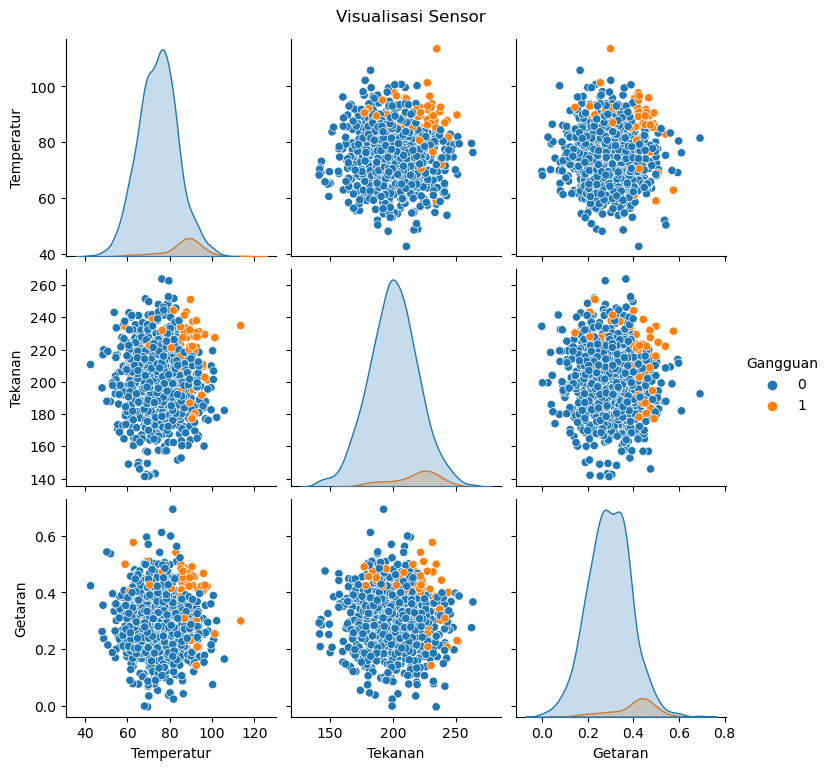

In [4]:
# Plot distribusi
sns.pairplot(df, hue='Gangguan')
plt.suptitle("Visualisasi Sensor", y=1.02)
plt.show()

Grafik menunjukkan hubungan antara suhu, tekanan, dan getaran turbin dengan kondisi gangguan. Titik berwarna oranye mewakili kasus gangguan, dan terlihat cenderung muncul ketika nilai sensor berada di atas normal — misalnya suhu di atas 85°C, tekanan di atas 220, atau getaran di atas 0.4. Hal ini menunjukkan bahwa gangguan lebih mungkin terjadi saat dua atau lebih parameter sensor menunjukkan nilai ekstrem. Visualisasi ini mengonfirmasi bahwa ketiga fitur sensor yang digunakan cukup informatif untuk membedakan kondisi normal dan bermasalah sehingga mendukung keakuratan model prediktif yang dibangun.

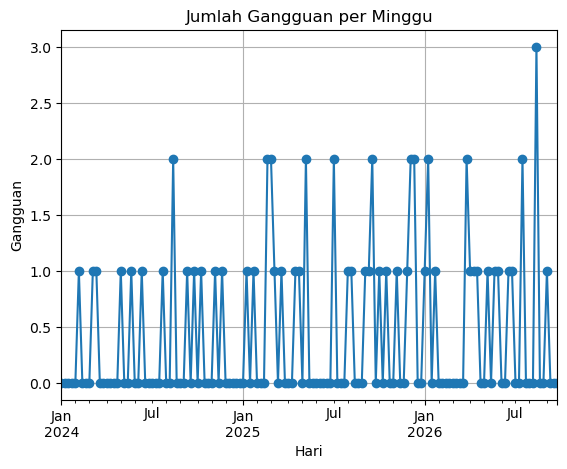

In [5]:
# Tren mingguan
df.set_index('Hari')['Gangguan'].resample('W').sum().plot(marker='o')
plt.title("Jumlah Gangguan per Minggu")
plt.ylabel("Gangguan")
plt.grid(True)
plt.show()

Interpretasi: Grafik tren mingguan menunjukkan bahwa gangguan pada turbin bersifat fluktuatif dan sporadis. Sebagian besar minggu relatif aman, namun ada periode tertentu dengan frekuensi gangguan yang meningkat. Tren ini penting untuk mendukung pengambilan keputusan pemeliharaan berbasis data (predictive maintenance).

## 4. Preprocessing
Karena dataset ini bersifat sintetis dan dibangun secara terkontrol, maka tidak ditemukan missing values atau noise. Nilai-nilai ekstrem justru merepresentasikan potensi gangguan dan harus dipertahankan. Oleh karena itu, preprocessing difokuskan pada proses penskalaan dan penyeimbangan kelas untuk memastikan model dapat belajar secara optimal.

In [6]:
X = df[['Temperatur', 'Tekanan', 'Getaran']]
y = df['Gangguan']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

## 5. Pelatihan Model
Tiga model akan dibandingkan: Random Forest, Logistic Regression, dan SVM.

In [7]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "SVM": SVC(probability=True, class_weight='balanced', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'cv': cross_val_score(model, X_bal, y_bal, cv=5).mean(),
        'report': classification_report(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }


## 6. Visualisasi Evaluasi


Model: Random Forest
Accuracy: 0.99 | ROC AUC: 1.00 | CV: 1.00
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       282
           1       0.99      0.99      0.99       281

    accuracy                           0.99       563
   macro avg       0.99      0.99      0.99       563
weighted avg       0.99      0.99      0.99       563



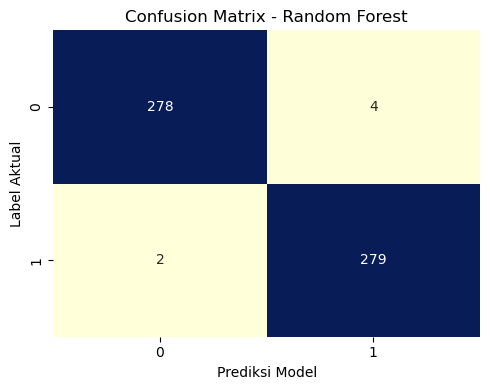

📌 Catatan: Baris = Label Aktual, Kolom = Prediksi Model

Model: Logistic Regression
Accuracy: 0.91 | ROC AUC: 0.96 | CV: 0.92
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       282
           1       0.88      0.95      0.92       281

    accuracy                           0.91       563
   macro avg       0.92      0.91      0.91       563
weighted avg       0.92      0.91      0.91       563



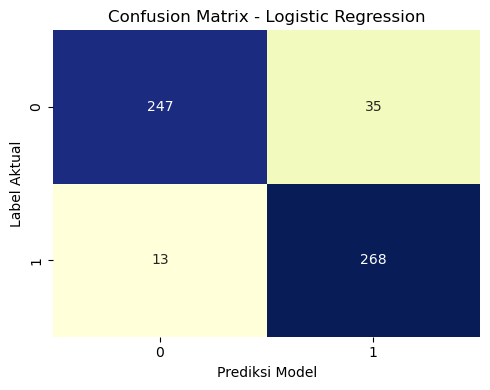

📌 Catatan: Baris = Label Aktual, Kolom = Prediksi Model

Model: SVM
Accuracy: 0.98 | ROC AUC: 1.00 | CV: 0.98
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       282
           1       0.96      0.99      0.98       281

    accuracy                           0.98       563
   macro avg       0.98      0.98      0.98       563
weighted avg       0.98      0.98      0.98       563



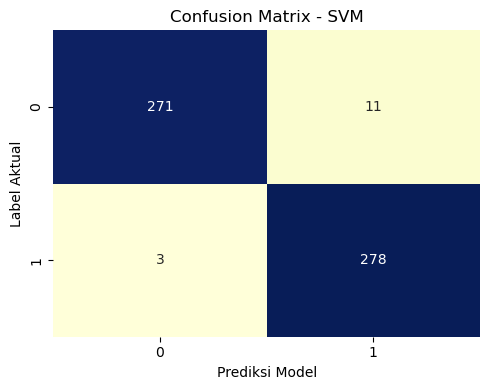

📌 Catatan: Baris = Label Aktual, Kolom = Prediksi Model


In [8]:
# Confusion Matrix & ROC AUC
for name, res in results.items():
    print(f"\nModel: {name}")
    print(f"Accuracy: {res['accuracy']:.2f} | ROC AUC: {res['roc_auc']:.2f} | CV: {res['cv']:.2f}")
    print(res['report'])

    plt.figure(figsize=(5,4))
    sns.heatmap(res['confusion'], annot=True, fmt='d', cmap='YlGnBu', cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Prediksi Model")   # Keterangan kolom
    plt.ylabel("Label Aktual")     # Keterangan baris
    plt.tight_layout()
    plt.show()

    print("📌 Catatan: Baris = Label Aktual, Kolom = Prediksi Model")


Interpretasi:   
Confusion matrix menggambarkan seberapa baik model mampu mengklasifikasikan data secara benar. Nilai di diagonal utama (kiri atas dan kanan bawah) menunjukkan jumlah prediksi yang benar (True Positive & True Negative), sedangkan nilai di luar diagonal adalah kesalahan klasifikasi.

🔹 Random Forest mencatat akurasi sangat tinggi (99%), hanya 4 false positive (alarm palsu) dan 2 false negative (gangguan tidak terdeteksi).   
🔹 SVM juga sangat baik (98%), dengan kesalahan sedikit lebih banyak dibanding RF.   
🔹 Logistic Regression memiliki akurasi terendah (91%), lebih banyak memberi alarm palsu dan kadang gagal deteksi.   

✅ Kesimpulan: Random Forest paling ideal untuk sistem monitoring turbin PLN karena sangat akurat, minim kesalahan, dan efisien.

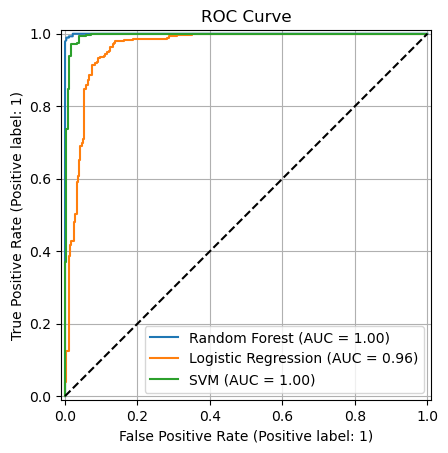

In [9]:
# ROC Curve
plt.figure()
for name, res in results.items():
    RocCurveDisplay.from_estimator(res['model'], X_test, y_test, name=name, ax=plt.gca())
plt.plot([0,1],[0,1],'k--')
plt.grid()
plt.title("ROC Curve")
plt.show()

Kurva ROC di atas menunjukkan kemampuan model dalam membedakan antara kondisi turbin yang normal dan yang mengalami gangguan. Garis diagonal hitam (putus-putus) adalah baseline — yaitu performa model acak. Semakin jauh kurva dari garis ini ke arah kiri atas, semakin baik kemampuan model. Random Forest dan SVM tampil sangat unggul dengan skor AUC sempurna (1.00), menandakan prediksi nyaris tanpa kesalahan. Logistic Regression juga menunjukkan performa yang sangat baik (AUC 0.96), meskipun sedikit lebih rendah. Secara keseluruhan, Random Forest menjadi pilihan utama karena akurat, efisien, dan cocok untuk integrasi dalam sistem pemantauan turbin secara real-time.

## 7. Feature Importance

Analisis ini menggunakan model Random Forest, yang sebelumnya terbukti memiliki performa terbaik (akurasi 99%, AUC 1.00). Selain akurat, Random Forest juga memungkinkan kita mengetahui fitur mana yang paling berpengaruh dalam mendeteksi gangguan. Hal ini penting untuk membantu teknisi fokus pada parameter sensor yang paling krusial.

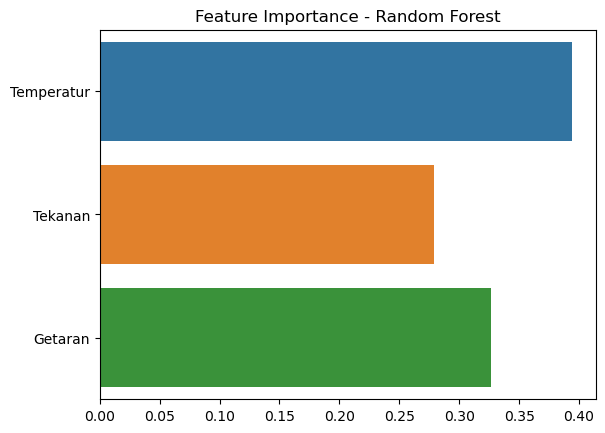

In [10]:
# Random Forest Feature Importance
rf = results['Random Forest']['model']
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.title("Feature Importance - Random Forest")
plt.show()

Hasil analisis menunjukkan bahwa temperatur adalah faktor paling berpengaruh dalam mendeteksi gangguan pada turbin, diikuti oleh getaran dan tekanan. Ini berarti perubahan ekstrem pada suhu operasi cenderung menjadi sinyal awal gangguan, sehingga pemantauan suhu secara real-time sangat krusial. Meskipun tekanan dan getaran juga penting, pengaruhnya sedikit lebih rendah dibanding suhu. Temuan ini sejalan dengan prinsip engineering di lapangan, di mana lonjakan temperatur sering menjadi indikator pertama dari kegagalan mekanis atau ketidakseimbangan sistem. Dengan demikian, model tidak hanya akurat, tetapi juga menghasilkan insight yang dapat ditindaklanjuti secara praktis.

##  8. Deployment-ready Pipeline & Monitoring Function

Untuk menyiapkan model agar dapat digunakan dalam sistem nyata (production-ready), dibuat pipeline yang menggabungkan proses scaling data dan prediksi dalam satu langkah. Pipeline ini dilatih ulang menggunakan seluruh dataset agar mendapatkan performa terbaik.

Selanjutnya, disusun fungsi monitor_turbine() yang menerima input tiga sensor (temperatur, tekanan, getaran) dan mengembalikan status kondisi turbin secara real-time:
- NORMAL ✅ bila probabilitas gangguan rendah
- WASPADA ❗ bila probabilitas sedang
- KRITIS ⚠️ bila probabilitas gangguan sangat tinggi

In [11]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])
final_pipeline.fit(X, y)

def monitor_turbine(temperatur, tekanan, getaran):
    input_data = pd.DataFrame([[temperatur, tekanan, getaran]], columns=['Temperatur', 'Tekanan', 'Getaran'])
    pred = final_pipeline.predict(input_data)[0]
    proba = final_pipeline.predict_proba(input_data)[0][1]

    if proba > 0.7:
        return f"KRITIS ⚠️ (Prob: {proba:.2f})"
    elif proba > 0.4:
        return f"WASPADA ❗ (Prob: {proba:.2f})"
    else:
        return f"NORMAL ✅ (Prob: {proba:.2f})"

# Contoh pemakaian fungsi pemantauan:
monitor_turbine(90, 230, 0.5)

'KRITIS ⚠️ (Prob: 1.00)'

Fungsi ini dirancang agar mudah diintegrasikan ke dalam dashboard SCADA/IIoT atau alert system di lingkungan pembangkit. Contohnya, input Temperatur=90, Tekanan=230, Getaran=0.5 menghasilkan status KRITIS (Prob: 1.00), menunjukkan bahwa sistem berhasil mengenali pola yang sangat berisiko. Fungsi ini juga dapat dijadikan backend untuk dashboard atau alert system PLN


## 9. Kesimpulan

Proyek ini berhasil membangun model machine learning untuk predictive maintenance turbin PLTU menggunakan data sensor sintetis (temperatur, tekanan, dan getaran). Berdasarkan eksplorasi data dan evaluasi model, ditemukan bahwa gangguan turbin cenderung terjadi saat dua atau lebih sensor menunjukkan anomali, misalnya suhu tinggi dan getaran berlebih secara bersamaan.

Dari tiga model yang diuji, Random Forest menunjukkan performa terbaik dengan akurasi 99% dan nyaris tanpa kesalahan klasifikasi, diikuti oleh SVM (98%) dan Logistic Regression (91%). Hasil ini juga didukung oleh kurva ROC yang sangat baik (AUC = 1.00 untuk Random Forest dan SVM). Analisis feature importance menunjukkan bahwa suhu dan getaran merupakan indikator paling kuat terhadap potensi gangguan.

Model yang dibangun dapat digunakan dalam sistem pemantauan PLN berbasis SCADA/IIoT untuk memberikan peringatan dini terhadap potensi kegagalan turbin. Pendekatan ini membantu mengurangi risiko kerusakan besar, meningkatkan efisiensi operasional, dan memperpanjang umur aset pembangkit.